# Milan Kovacs
## 21308128

Task:  
Replicate the classifier training and evaluation demonstrated in the example notebook Lab 4 - Comparison of Binary Classifiers.ipynb but with the dataset seeds.csv. You will need to formulate a binary classification problem and transform the type column accordingly. That is, replace the type column with a binary column called class in which one of the original three types (it doesn't matter which one you choose) is class 0, and the other two types are class 1.


In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## Exploratory Data Analysis

In [3]:
df = pd.read_csv("./seeds.csv")
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [4]:
df.tail()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


In [5]:
df['type'].value_counts()

type
1    70
2    70
3    70
Name: count, dtype: int64

I will try and classify `Type 1`, meaning `Type 2` and `Type 3` are the incorrect ones.

We have 3 classifications and it is balanced

In [6]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

No missing values, thus we can continue with processing the data. We have 7 attributes and 1 target value, we can do two boxplots of 4 and 3.

In [7]:
df.loc[:, 'area': 'length of kernel'].describe()

,area,perimeter,compactness,length of kernel
count,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533
std,2.909699,1.305959,0.023629,0.443063
min,10.590000,12.410000,0.808100,4.899000
25%,12.270000,13.450000,0.856900,5.262250
50%,14.355000,14.320000,0.873450,5.523500
75%,17.305000,15.715000,0.887775,5.979750
max,21.180000,17.250000,0.918300,6.675000


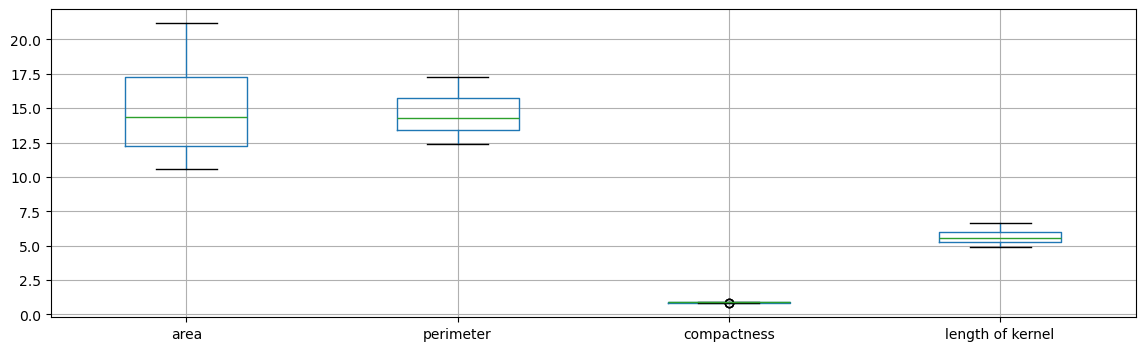

In [8]:
df.loc[:, 'area': 'length of kernel'].boxplot(figsize=(14, 4))
plt.show()

In [9]:
df.loc[:, 'width of kernel': 'length of kernel groove'].describe()

,width of kernel,asymmetry coefficient,length of kernel groove
count,210.000000,210.000000,210.000000
mean,3.258605,3.700201,5.408071
std,0.377714,1.503557,0.491480
min,2.630000,0.765100,4.519000
25%,2.944000,2.561500,5.045000
50%,3.237000,3.599000,5.223000
75%,3.561750,4.768750,5.877000
max,4.033000,8.456000,6.550000


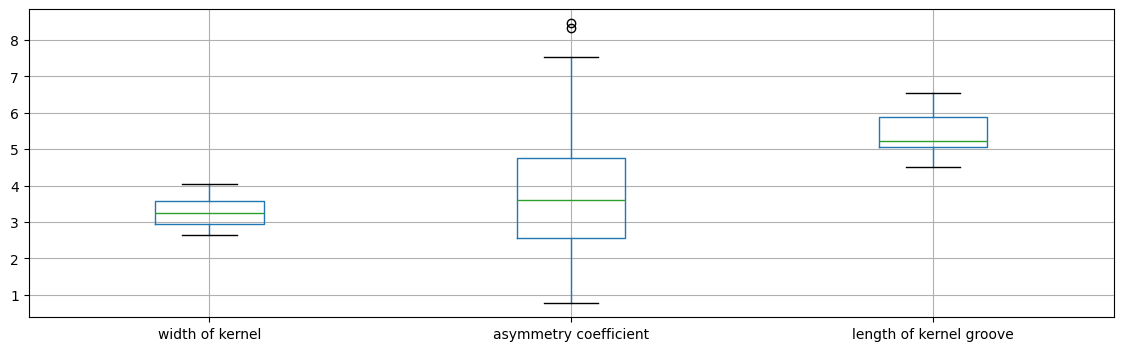

In [10]:
df.loc[:, 'width of kernel': 'length of kernel groove'].boxplot(figsize=(14, 4))
plt.show()

`Compactness` and `Asymmetry Coefficient` are the two attributes with outliers.

In [11]:
df.hist(figsize=(25,20))

array([[<Axes: title={'center': 'area'}>,
        <Axes: title={'center': 'perimeter'}>,
        <Axes: title={'center': 'compactness'}>],
       [<Axes: title={'center': 'length of kernel'}>,
        <Axes: title={'center': 'width of kernel'}>,
        <Axes: title={'center': 'asymmetry coefficient'}>],
       [<Axes: title={'center': 'length of kernel groove'}>,
        <Axes: title={'center': 'type'}>, <Axes: >]], dtype=object)

## Data Preperation

We will convert our target column (`type`) into classification types

In [12]:
mapper = {1: 1, 2: 0, 3: 0}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()

type
0    140
1     70
Name: count, dtype: int64

So now our dataset is inbalanced. 

In [13]:
# y is our target
# x is all the other attributes
y = df['type']
x = df.drop('type', axis=1)

In [14]:
#`Compactness` and `Asymmetry Coefficient` are the two attributes with outliers.
attributes_no_outliers = [ 'asymmetry coefficient']


In [15]:
attributes_outliers_and_zeros = ['compactness']

In [16]:
attributes_outliers_no_zeros = [
    i for i in list(x.columns) if i not in attributes_no_outliers and 
                                  i not in attributes_outliers_and_zeros
]

print(attributes_outliers_no_zeros)
print(len(attributes_outliers_no_zeros))

['area', 'perimeter', 'length of kernel', 'width of kernel', 'length of kernel groove']
5


In [17]:
outliers_no_zeros_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.log)), 
        ("scaler", RobustScaler())
    ]
)

outliers_and_zeros_pipeline = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.cbrt)),
        ("scaler", RobustScaler())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("outliers_no_zeros", outliers_no_zeros_pipeline, attributes_outliers_no_zeros),    
        ("outliers_and_zeros", outliers_and_zeros_pipeline, attributes_outliers_and_zeros),
        ("no_outliers", FunctionTransformer(np.cbrt), attributes_no_outliers)
    ],
    remainder="passthrough"
)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, stratify=y)

## Model Training

### SVM

In [19]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

#### Visualization of the Pipeline

In [21]:
set_config(display='diagram')
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outliers_no_zeros',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['area', 'perimeter',
                                                   'length of kernel',
                                                   'width of kernel',
                                                   'length of kernel groove']),
                                                 ('outliers_and_zeros',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['compactness']),
                                                 ('no_outliers',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['asymmetry coefficient'])])),
                ('svm', SVC(probability=True))])

In [63]:
hyper_parameters = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear', 'poly']
    }

search = GridSearchCV(pipe, hyper_parameters, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print(f"The best CV score is {search.best_score_:0.3f}")
print(f"Best parameters: {search.best_params_}")

SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

The best CV score is 0.970
Best parameters: {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


## Random Forest

In [64]:
# Pipeline
pipe_rf = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

### Visualize Pipeline 2

In [65]:
set_config(display='diagram')
pipe_rf

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outliers_no_zeros',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['area', 'perimeter',
                                                   'length of kernel',
                                                   'width of kernel',
                                                   'length of kernel groove']),
                                                 ('outliers_and_zeros',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['compactness']),
                                                 ('no_outliers',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['asymmetry coefficient'])])),
                ('rf', RandomForestClassifier())])

### Hyper Tuning

In [66]:
hyper_parameters_rf = {
    'rf__n_estimators': [10,20,30],
    'rf__max_depth': [2,4,6,8]
}

search_rf = GridSearchCV(pipe_rf, hyper_parameters_rf, n_jobs=-1, cv=5, refit=True)
search_rf.fit(X_train, y_train)
print(f"The best CV score is {search_rf.best_score_:0.3f}")
print(f"Best parameters: {search_rf.best_params_}")

RF_best_params = search_rf.best_params_
RF_best_model = search_rf.best_estimator_

The best CV score is 0.934
Best parameters: {'rf__max_depth': 8, 'rf__n_estimators': 10}


## Naive Bayes

Task 3  
Train a third probabilistic classifier (e.g., MLPClassifier, Naive Bayes, kNN) with seeds.csv add compare it to both SVM and Random Forest. You may encounter warnings for 0 values of some of the metrics. Ignore them and aim at having at least one classifier that has acceptable results.

In [69]:
from sklearn.naive_bayes import GaussianNB


In [70]:
pipe_nb = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', GaussianNB())])

In [71]:
set_config(display='diagram')
pipe_nb

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outliers_no_zeros',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['area', 'perimeter',
                                                   'length of kernel',
                                                   'width of kernel',
                                                   'length of kernel groove']),
                                                 ('outliers_and_zeros',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['compactness']),
                                                 ('no_outliers',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>),
                                                  ['asymmetry coefficient'])])),
                ('rf', GaussianNB())])

In [73]:
# Define the parameter grid
hyper_parameters_nb = {
    'rf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6],
    }

search_nb = GridSearchCV(pipe_nb, hyper_parameters_nb, n_jobs=-1, cv=5, refit=True)
search_nb.fit(X_train, y_train)
print(f"The best CV score is {search_nb.best_score_:0.3f}")
print(f"Best parameters: {search_nb.best_params_}")

NB_best_params = search_nb.best_params_
NB_best_model = search_nb.best_estimator_

The best CV score is 0.922
Best parameters: {'rf__var_smoothing': 1e-09}


## Compare Classifers on Test Set

In [74]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [75]:
def eval_mdl(X_test, y_test, model):
    _probabilities = model.predict_proba(X_test)[:, 1]

    _predicted_values = model.predict(X_test)

    _accuracy = accuracy_score(y_test, _predicted_values)

    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])

    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)

    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

    _auc = auc(_fpr, _tpr)

    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc


In [76]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = eval_mdl(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = eval_mdl(X_test, y_test, RF_best_model)
NB_accuracy, NB_precision, NB_recall, NB_f1_score, NB_tpr, NB_auc = eval_mdl(X_test, y_test, NB_best_model)

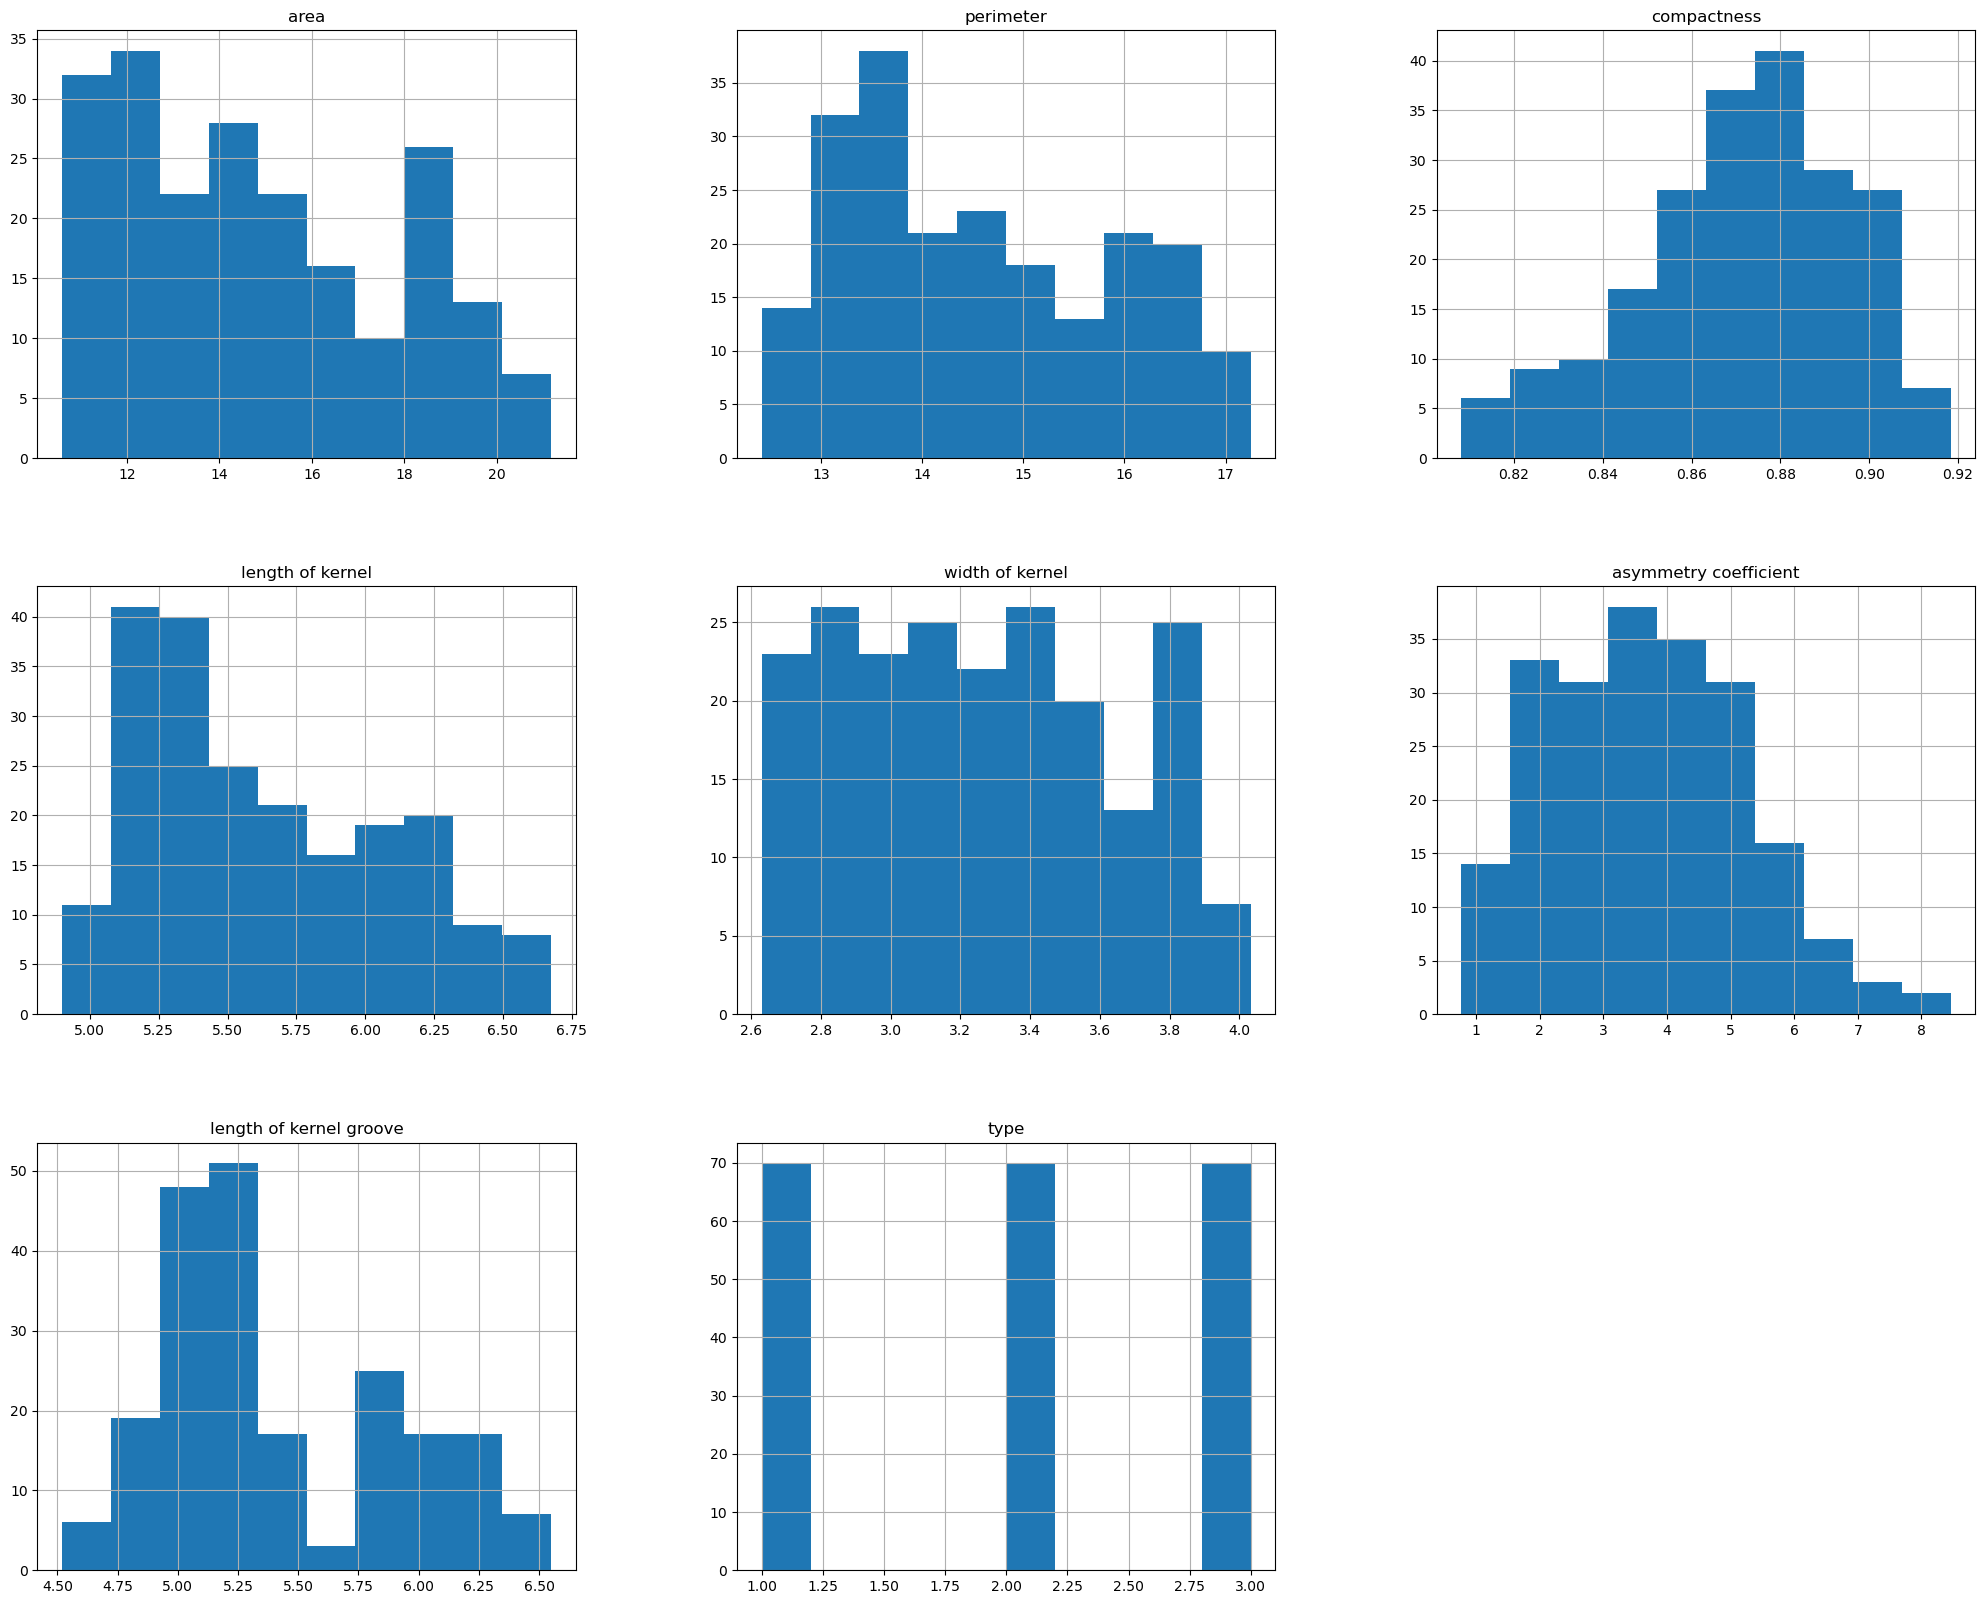

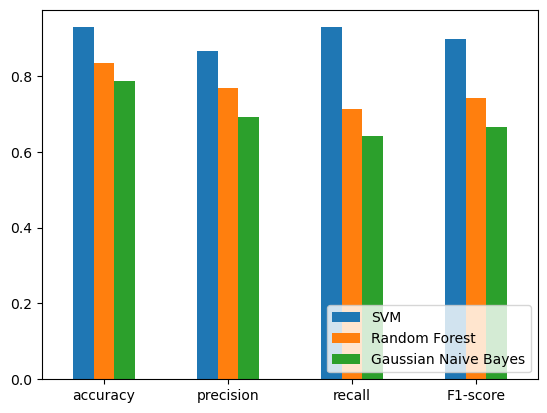

In [77]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
NB_metrics = np.array([NB_accuracy, NB_precision, NB_recall, NB_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'Gaussian Naive Bayes': NB_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

### Evaluation of the classifiers
We can see that the order of the classifiers is the same for all metrics SVM, Random Forests and then Gaussian Naive Bayes. The SVM classifier has the best accuracy, precision, recall and F1-score. The Random Forest classifier has the second best accuracy, precision, recall and F1-score. The Gaussian Naive Bayes classifier has the worst accuracy, precision, recall and F1-score.

Now some considerations about the metrics:
- The data set is skewed, we have twice as many negative classifications data in contrast to positive data. 

The accuracy is very well performed by SVM, appears to be almost or little over 90%. This is the Total positively classified out of the total data.

The precision is the ratio of correctly predicted positive observations to the total predicted positives. Once again SVM outperforms the other classifiers.

The recall is the ratio of correctly predicted positive observations to the all observations in actual class. SVM has the best recall.

The F1 score is the weighted average of Precision and Recall. This score takes both false positives and false negatives into consideration. It is a good way to show that a classifier has a good value for both false positives and false negatives. SVM has the best F1 score.

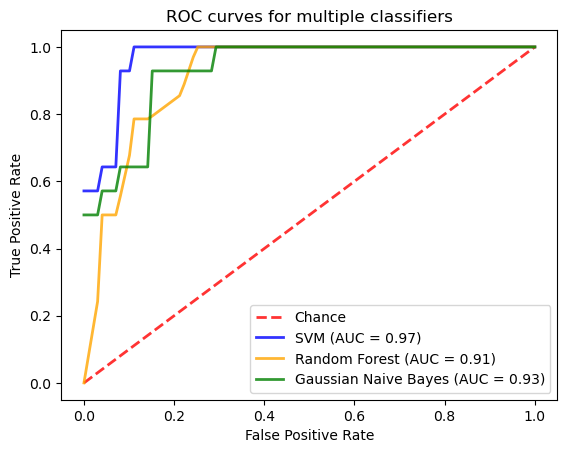

In [78]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, NB_tpr[0,:], lw=2, color='green', label='Gaussian Naive Bayes (AUC = %0.2f)' % (NB_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

### Area Under Curve evaluation
SVM has a really good performance with what appears to be nearly 100% true positive rat with less than 10% of false positive rate. At some point GNB has out performed random forest.

Some consideration:
- Gaussian Naive Bayes is a probabilistic model that assumes that all features are indepdent. Now this might explain the weaker performance since we are classifying seeds and there is potentially correlation between the features.
- Random Forests uses multiple decision trees, where each tree is trained on a random subset of the data. Then during classification, it takes the majority of all the votes from all the trees.
- SVM tries to find the best hyperplane that maximises the margin between the classes. It appears due this classification strategy it has outperformed the other classifiers. 

## Training the final model

In [80]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params

def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(x, y)

In [82]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))